#### Winner's Curse

Commonly, a business would like to determine the total effect of a product optimisation program. One simple way of estimating the net effect is through summing up the net uplift of each successful experiment. There are a number of potential problems associated with this methodology:

- Adding up several point estimates ignores the variability of each estimate.
- Seasonality effects: the impact of a feature may vary over time
- A/B experiments measure the short-term impact of features. The total sum of these short term effects may not be a good measure of the long-term impact of an experimentation program.

Winner's curse ([AirBnB's Blog Post](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb) and accompanying [video](http://videolectures.net/kdd2018_lee_curse_estimation/)) is another potential source of error when estimating the total effect of multiple launched features. Even if the considerations above were null, our estimate of the totla effect of all launched features would likely be an overestimate due to this selection bias. 

The use of a holdout set neatly avoids these problems and measures the long-term impact of launched features. Should this not be possible, a data scientist should be aware of the problems mentioned above. In their blogpost, AirBnB provide a measure to remove this selection bias from the estimate.

In this blog post, I will simulate the effect of winner's bias.

In [93]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

In [9]:
# RANDOM_STATE = 42

In [94]:
# true_effect = .1
# norm.rvs(loc=true_effect, scale=1, size=1)

In [95]:
class Experiment:
    def __init__(self, true_effect, sd=1, n=10):
        self.true_effect = true_effect
        self.sd = sd
        observations = norm.rvs(true_effect, sd, n)
        self.observed_effect = np.average(observations)
        
    def is_significant(self):
        # null hypothesis is no true effect
        # alpha value of 0.05 has t_crit of 1.96 for two-sided t-test
        return True if self.observed_effect / self.sd > 1.96 else False

In [159]:
def simulate_experiments(n_experiments=10):
    
    # generate a selection of random normally distributed true effects
    true_effects = np.random.normal(loc=2, scale=1, size=n_experiments)

    experiments = [Experiment(true_effect) for true_effect in true_effects]
    significant = [e for e in experiments if e.is_significant()]
    total_true_effect = np.sum([s.true_effect for s in significant])
    total_observed_effect = np.sum([s.observed_effect for s in significant])
    
    return (total_true_effect, total_observed_effect)

In [160]:
total_true_effects = []
total_observed_effects = []
for _ in range(1000):
    total_true_effect, total_observed_effect = simulate_experiments()
    total_true_effects.append(total_true_effect)
    total_observed_effects.append(total_observed_effect)

In [161]:
df = pd.DataFrame(index = total_true_effects, 
                  data = total_observed_effects,
                  columns = ['Bottoms-up Effect'])
df.index.name = 'True Effect'

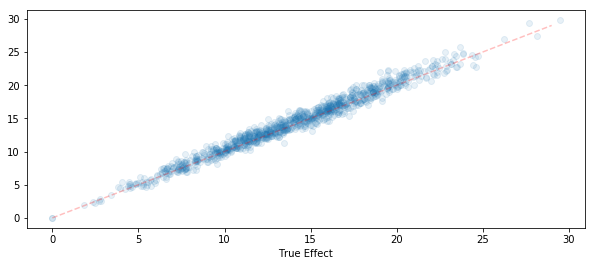

In [163]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
df.plot(style='o', alpha=0.1, ax=ax)

# plot an x, y line
x = np.linspace(0, int(np.max(total_true_effects)), 100)
plt.plot(x,x, '--r', alpha=0.25)
ax.legend().set_visible(False)

Why are there points below the y=x line?